<img align="center" src="http://emba.eduego.com/Uploads/Ueditor/image/20180130/1517298966389236.jpg">
<h1 align="center" style="margin-top:10px">Conditional Monte-Carlo of OUSV and GARCH-diffusions</h1>
<h2 align="center" style="margin-top:20px">Team：Li Panyu, Li Linxiong</h2>
<br>

# 1. The Ornstein-Uhlenbeck stochastic volatility (OUSV) model

The ___Ornstein–Uhlenbeck process___ is an example of a ___Gaussian process___ that has a bounded variance and admits a stationary probability distribution, in contrast to the Wiener process; the difference between the two is in their "drift" term. For the Wiener process the drift term is constant, whereas for the Ornstein–Uhlenbeck process it is dependent on the current value of the process: if the current value of the process is less than the (long-term) mean, the drift will be positive; if the current value of the process is greater than the (long-term) mean, the drift will be negative. In other words, the mean acts as an equilibrium level for the process. This gives the process its informative name, "___mean-reverting___" 

### **Underline price process-following GBM**

$$\frac{dF_t}{F_t}=\sigma_t(\rho\,dB_t + \rho_*dX_t) \tag{1}$$

### **Volatility process-following OUSV**
$$d\sigma_t=\kappa\,(\theta-\sigma_t)\,dt+\xi\,dB_t \tag{2}$$  
**Solution**
$$\sigma_t=e^{-\kappa t}\sigma_0+\theta(1-e^{-\kappa t})+\frac{\sigma e^{-\kappa t}}{\sqrt{2\kappa}}B_{e^{-\kappa t}\, -1}\tag{3}$$
$$B_{e^{-\kappa t}\, -1}-B_{e^{-\kappa s}\, -1}\sim N(0, e^{-2\kappa t}-e^{-2\kappa s})\tag{4}$$  
**Mathematical properties**
$$E(\sigma_t)=\sigma_0 e^{-\kappa t}+\theta(1-e^{-\kappa t}) \tag{5}$$  
$$var(\sigma_T) = \frac{\xi^2}{2\kappa}(1-e^{-2\kappa t}) \tag{6}$$
$$cov(\sigma_s, \sigma_t)=\frac{\xi^2}{2\kappa}(e^{-\kappa|t-s|}-e^{-\kappa(t+s)}) \tag{7}$$

### **Expectation and BS volatilitty of stock price $F_T$**
$$F_T=F_0 exp\left(\frac{\rho}{\xi}({\sigma_T}^2-{\sigma_0}^2)-\frac{\rho\xi}{2}T-\frac{\rho\kappa\theta}{\xi}U_T+(\frac{\rho\kappa}{\xi}-\frac{\rho^2}{2})V_T\right)\,\,\,\,,where\,\,U_T=\int_{0}^{T}\sigma_tdt\,\,,and\,\,V_T=\int_{0}^{T}\sigma^2_tdt\tag{8}$$

$$\sigma_{BS} = \rho_*\sqrt{V_T/T} \tag{9}$$

### **OUSV conditional MC steps**

|**Tags**| **Steps** | **Formulas of algorithm** |
|----| - - - - | - - - - |
|**1**| Simulate BM increment and cumsum | $$B_{e^{-\kappa t}\, -1}-B_{e^{-\kappa s}\, -1}\sim N(0, e^{-2\kappa t}-e^{-2\kappa s})$$ |
|**2**| Simulate volatility path | $$\sigma_t=e^{-\kappa t}\sigma_0+\theta(1-e^{-\kappa t})+\frac{\sigma e^{-\kappa t}}{\sqrt{2\kappa}}B_{e^{-\kappa t}\, -1}$$ |
|**3**| Calculate forward conditional spot and volatility | $$F_T=F_0 exp\left(\frac{\rho}{\xi}({\sigma_T}^2-{\sigma_0}^2)-\frac{\rho\xi}{2}T-\frac{\rho\kappa\theta}{\xi}U_T+(\frac{\rho\kappa}{\xi}-\frac{\rho^2}{2})V_T\right)\,\,,\,\,\sigma_{BS} = \rho_*\sqrt{V_T/T}$$|
|**4**| Use BSM to calculate the option price |$$C_T=F_0N(d_1)-KN(d_2),d_{1,2}=\frac{log(F_0/K)}{\sigma\sqrt{T}}\pm\frac{1}{2}\sigma\sqrt{T}$$ |

where:  
$V_T=\int_0^T{\sigma_t}^2dt, U_T=\int_0^T\sigma_tdt$  
$F_t$ is the forward asset price,  
$\kappa$ is the speed of mean reversion,  
$\theta$ is the long-term volatility,  
$\xi$ is the volatility of the volatility $\sigma_t$,  
$\rho$ is the instantaneous correlation between asset price and volatility, $\rho_*=\sqrt{1-\rho^2}$   
$B_t$ and $X_t$ are two independent Brownian motions  

## OUSV Test

By setting the same parameter, we compare our results with the results of Li & Wu. (2018)'s exact method and the exact prices.  

References:  
Li, C., & Wu, L. (2019). Exact simulation of the Ornstein–Uhlenbeck driven stochastic volatility model. European Journal of Operational Research, 275(2), 768-779. https://doi.org/10.1016/j.ejor.2018.11.057

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(sys.path.index('') + 1, 'E:\PHBS\8.ASP\PyFENG')
# sys.path.insert(sys.path.index('') + 1, 'C:/Users/cherr/Documents/GitHub/PyFeng')
import pyfeng as pf
from tqdm import tqdm
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

## 1.1 Test sample 1

**True value: 13.21493, 40.79773, 62.76312**

In [3]:
strike = np.array([100])
spot = 100
texp = np.array([1, 5, 10])
ousv = pf.OusvCondMC(sigma = 0.2, mr=4, vov = 0.1, rho=-0.7, intr=0.09531)
ousv.set_mc_params(dt=0.02, n_path=500000, rn_seed=123456, antithetic=False)
ousvift = pf.OusvIft(0.2, mr=4, vov=0.1, rho=-0.7, intr=0.09531)

#### 1.1.1 Conditional MC of OUSV

In [4]:
p_ousv = ousv.price(strike, spot, texp)
ousv_df = pd.DataFrame(data=p_ousv,columns=[texp],index=strike)
ousv_df

,1,5,10
100,13.189209,40.869062,62.807413


#### 1.1.2 Exact simulation of OUSV

In [5]:
p_ousvift=ousvift.price(100, 100, texp=np.array([1, 5, 10]))
ousvift_df = pd.DataFrame(data=p_ousvift[:,None].T,columns=np.array([1, 5, 10]),index=[100])
ousvift_df

,1,5,10
100,13.213412,40.785145,62.674277


#### 1.1.3 Difference between CondMC and Exact

In [6]:
pd.DataFrame(data=(ousv_df.values - ousvift_df.values),columns=np.array([1, 5, 10]),index=[100])

,1,5,10
100,-0.024203,0.083918,0.133137


#### 1.1.4 Difference between CondMC and True value

In [7]:
true_values = np.array([13.21493, 40.79773, 62.76312])
pd.DataFrame(data=(ousv_df.values - true_values),columns=np.array([1, 5, 10]),index=[100])

,1,5,10
100,-0.025721,0.071332,0.044293


## 1.2 Test sample 2

**True value: 21.41873, 15.16798, 10.17448**

In [8]:
strike = np.array([90, 100, 110])
spot = 100
texp = 1
ousv = pf.OusvCondMC(sigma = 0.25, mr=8, vov = 0.3, rho=-0.6, intr=0.09531)
ousv.set_mc_params(dt=0.02, n_path=500000, rn_seed=123456)
ousvift = pf.OusvIft(0.25, mr=8, vov=0.3, rho=-0.6, intr=0.09531)

#### 1.1.1 Conditional MC of OUSV

In [9]:
p_ousv = ousv.price(strike, spot, texp)
ousv_df = pd.DataFrame(data=p_ousv,columns=[texp],index=strike)
ousv_df

,1
90,21.428550
100,15.178008
110,10.183465


#### 1.1.2 Exact simulation of OUSV

In [10]:
p_ousvift=ousvift.price(np.array([90, 100, 110]), 100, texp=1)
ousvift_df = pd.DataFrame(data=p_ousvift[:,None],columns=[texp],index=np.array([90, 100, 110]))
ousvift_df

,1
90,21.416243
100,15.165753
110,10.171460


#### 1.1.3 Difference between CondMC and Exact

In [11]:
pd.DataFrame(data=(ousv_df.values - ousvift_df.values),columns=[texp],index=np.array([90, 100, 110]))

,1
90,0.012308
100,0.012255
110,0.012005


#### 1.1.4 Difference between CondMC and True value

In [12]:
true_values = np.array([21.41873, 15.16798, 10.17448])
pd.DataFrame(data=(ousv_df.values.T - true_values).T,columns=[texp],index=np.array([90, 100, 110]))

,1
90,0.009820
100,0.010028
110,0.008985


## 1.3 Test sample 3

In [13]:
strike = np.linspace(75,125,num=10)
spot = 100
texp = 1
ousv = pf.OusvCondMC(sigma=0.2, vov=0.5, rho=0.7, mr=2, theta=1)
ousv.set_mc_params(dt=0.02, n_path=500000, rn_seed=123456)
ousv_ift = pf.OusvIft(sigma=0.2, mr=2, vov=0.5, rho=0.7, theta=1)

#### 1.1.1 Conditional MC of OUSV

In [14]:
p_ousv = ousv.price(strike, spot, texp)
ousv_df = pd.DataFrame(data=p_ousv,columns=[texp],index=np.int64(np.around(strike))).T
ousv_df

,75,81,86,92,97,103,108,114,119,125
1,38.15038,35.63877,33.364992,31.302344,29.426949,27.717707,26.156088,24.725872,23.412879,22.204705


#### 1.1.2 Exact simulation of OUSV

In [15]:
p_ousvift = ousv_ift.price(strike, spot, texp)
ousvift_df = pd.DataFrame(data=p_ousvift,columns=[texp],index=np.int64(np.around(strike))).T
ousvift_df

,75,81,86,92,97,103,108,114,119,125
1,38.109676,35.598346,33.32456,31.26165,29.385771,27.675852,26.113393,24.682197,23.368102,22.158716


#### 1.1.3 Difference between CondMC and Exact

In [16]:
pd.DataFrame(data=(ousv_df.values - ousvift_df.values),index=[texp],columns=np.int64(np.around(strike)))

,75,81,86,92,97,103,108,114,119,125
1,0.040704,0.040424,0.040431,0.040694,0.041178,0.041855,0.042695,0.043675,0.044778,0.045989


## Volatility Simle

In [17]:
c_1=0.09
c_2=4
c_3=1.2

rho=0 # correlation between volatility and asset price
mr=c_2
vov=c_3
theta_ratio=1.0
sigma=np.sqrt(c_1/c_2) # start-up volatility
intr=0.0 # risk-free interest rate
divr=0.0 # dividend rate
strike=np.arange(90,111,1) # strike price
spot=100 # spot asset price
texp=1/252*np.array([30,40,50,60]) # time to maturity

ousv = pf.OusvCondMC(sigma=sigma, vov=vov, rho=rho, mr=mr, theta=c_1/c_2)
ousv.set_mc_params(dt=0.02, n_path=500000,rn_seed=123456)

In [18]:
impvol_1=np.zeros((len(strike),len(texp))) 
for i in tqdm(range(len(strike))):
    for j in range(len(texp)):
        impvol_1[i, j]=ousv.vol_smile(strike[i], spot, texp[j], cp=-1)[0, 0]

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:12<00:00,  3.44s/it]


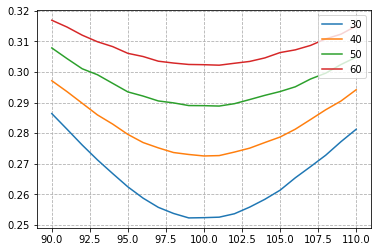

In [19]:
pd.DataFrame(data=impvol_1,columns=np.int64(np.around(texp*252)),index=strike).plot()
plt.legend(loc=1)
plt.grid(linestyle='--')

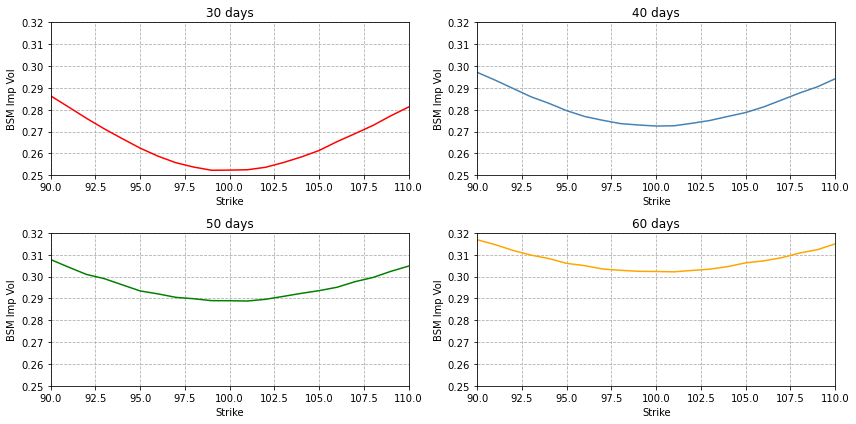

In [20]:
color = ['r', 'steelblue', 'g', 'orange']
plt.figure(figsize=(12,6))
for i in range(len(texp)):
    plt.subplot(221+i)
    plt.axis([90,110,0.25,0.32])
    plt.plot(strike,impvol_1[:,i], c=color[i])
    plt.ylabel('BSM Imp Vol')
    plt.xlabel('Strike')
    plt.title(str(int(round(252*texp[i])))+' days')
    plt.tight_layout()
    plt.grid(linestyle='--')
plt.show()

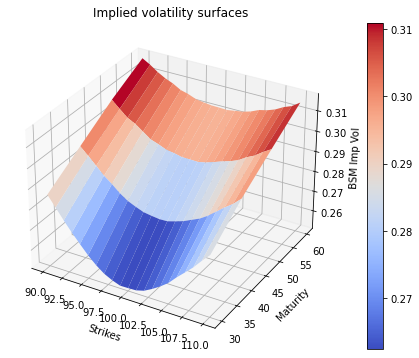

In [21]:
fig=plt.figure(figsize=(12,6))
ax = fig.gca(projection='3d')
surf=ax.plot_surface(strike.reshape(impvol_1.shape[0],1).repeat(impvol_1.shape[1],axis=1),(252*texp).reshape(1,impvol_1.shape[1]).repeat(impvol_1.shape[0],axis=0),impvol_1,cmap=cm.coolwarm)
ax.set_zlabel('BSM Imp Vol')
ax.set_ylabel('Maturity')
ax.set_xlabel('Strikes')
fig.colorbar(surf)
plt.title('Implied volatility surfaces')
plt.show()

# 2. The Garch diffusion model:

### **Underline price process-following GBM**

$$\frac{dF_t}{F_t}=\sigma_t(\rho\,dB_t + \rho_*dX_t) \tag{1}$$

### **Volatility process-following Garch diffusion model**
$$dv_t=\kappa\,(\theta-v_t)\,dt+\upsilon v_t\,dB_t,\ \ \  where\ \ v_t=\sigma_t^2 \tag{2}$$  

#### **Analytical solution of volatility**
$$v_t=e^{-(\kappa+\frac{\upsilon^2}{2})t+\upsilon B_t}\left(v_0+\kappa \theta \int_{0}^{t}e^{(\kappa+\frac{\upsilon^2}{2})s-\upsilon B_s}ds \right) \tag{3}$$

#### **Milstein scheme of $v_t$**  
Since the analytical solution of $v_t$ includes the integral of Brownain motion, we cannot get the volatility path from equation 3 directely. We need to utilize the Euler or Milstein scheme to get the path. The Euler and Milstein schemes for $v_t$ is given by:(the boxed term is noly for Milstein scheme)

$$ v_{t+\Delta t}-v_t=\kappa (\theta-v_t)\Delta t+\upsilon v_tZ_1\sqrt{\Delta t}+ \boxed{\frac{\upsilon^2}{2}v_t(Z_1^2-1)\Delta t} \tag{4}$$

Note: The SDE for $v_t$ tells us that $v_t$ cannot go negative. However, in the MC simulation, with the time-discretization scheme, $v_t$ sometimes go negative. To avoid this problem, it is better simulate $\omega_t = logv_t$ instead. The Euler and Milstein schemes for $\omega_t$ is given by:(two schemes are the same)

$$ \omega_{t+\Delta t}-\omega_t=(\kappa \theta e^{-\omega t}-\kappa - \upsilon^{2}/2)\Delta t + \upsilon Z_1\sqrt{\Delta t} \tag{5}$$

$$ v_{t+\Delta t}=v_t exp(\omega_{t+\Delta t}-\omega_t) \tag{6}$$

### **Expectation and BS volatilitty of stock price $F_T$**

$$F_T=F_0 exp\left(\frac{2\rho}{\upsilon}(\sigma_T-\sigma_0)-\frac{\rho\kappa\theta}{\upsilon}Y_T+\rho(\frac{\kappa}{\upsilon}+\frac{\upsilon}{4})U_T-\frac{\rho^2}{2}V_T\right)\,\,\,\,,where\,\,Y_T=\int_{0}^{T}\frac{1}{\sigma_t}dt\,\,,\,\,U_T=\int_{0}^{T}\sigma_tdt\,\,,and\,\,V_T=\int_{0}^{T}\sigma^2_tdt \tag{7}$$

$$\sigma_{BS} = \rho_*\sqrt{V_T/T} \tag{8}$$

### **Garch MC steps**

|**Tags**| **Steps** | **Formulas of algorithm** |
|----| - - - - | - - - - |
|**1**| Simulate volatility path | $$ \omega_{t+\Delta t}=\omega_t+(\kappa \theta e^{-\omega t}-\kappa - \upsilon^{2}/2)\Delta t + \upsilon Z_1\sqrt{\Delta t}\,\,,\,\,v_t=e^{\omega_t}$$ |
|**2**| Calculate forward conditional spot and volatility |$$F_T=F_0 exp\left(\frac{2\rho}{\upsilon}(\sigma_T-\sigma_0)-\frac{\rho\kappa\theta}{\upsilon}Y_T+\rho(\frac{\kappa}{\upsilon}+\frac{\upsilon}{4})U_T-\frac{\rho^2}{2}V_T\right)\,\,,\,\,\sigma_{BS} = \rho_*\sqrt{V_T/T}$$|
|**3**| Use BSM to calculate the option price |$$C_T=F_0N(d_1)-KN(d_2),d_{1,2}=\frac{log(F_0/K)}{\sigma\sqrt{T}}\pm\frac{1}{2}\sigma\sqrt{T}$$ |

where:  
$Y_T=\int_{0}^{T}\frac{1}{\sigma_t}dt\,\,,\,\,U_T=\int_{0}^{T}\sigma_tdt\,\,,and\,\,V_T=\int_{0}^{T}\sigma^2_tdt$
$F_t$ is the forward asset price,  
$\kappa$ is the speed of mean reversion,  
$\theta$ is the long-term volatility,  
$\upsilon$ is the volatility of the square of the volatility $\sigma_t$,  
$\rho$ is the instantaneous correlation between asset price and volatility, $\rho_*=\sqrt{1-\rho^2}$   
$B_t$ and $X_t$ are two independent Brownian motions  

## Garch TEST

By setting the same parameter, we compare our results with the results of Barone-Adesi et al. (2004)'s approximation exact method.  

References:  
Barone-Adesi, G., Rasmussen, H., Ravanelli, C., 2005. An option pricing formula for the GARCH diffusion model. Computational Statistics & Data Analysis, 2nd CSDA Special Issue on Computational Econometrics 49, 287–310. https://doi.org/10.1016/j.csda.2004.05.014

## 2.1 Test sample 1

In [22]:
c_1=0.16
c_2=18
c_3=1.8

rho=0# correlation between volatility and asset price
mr=c_2
theta_ratio=1.0
vov=c_3
sigma=np.sqrt(c_1/c_2) # start-up volatility
strike=np.arange(90,115,5) # strike price
spot=100 # spot asset price
texp=1/252*np.array([30,60,90,120,180,252,504]) # time to maturity

garch = pf.GarchCondMC(sigma=sigma, vov=vov, rho=rho, mr=mr, theta=c_1/c_2)
garch.set_mc_params(dt=0.01, n_path=100000,rn_seed=123456)

#### 2.1.1 Conditional MC of Garch

In [23]:
p = garch.price(strike, spot, texp, cp=-1)
pd.DataFrame(data=p,columns=np.int64(np.around(texp*252)),index=strike)

,30,60,90,120,180,252,504
90,0.000872,0.018887,0.068022,0.141990,0.334530,0.600841,1.559487
95,0.081166,0.302371,0.546020,0.783262,1.226298,1.705188,3.078051
100,1.294761,1.834119,2.250046,2.599173,3.185366,3.770786,5.334092
105,5.101202,5.353158,5.621918,5.880011,6.357161,6.869082,8.326759
110,10.002474,10.037193,10.115542,10.222448,10.479928,10.816128,11.962609


#### 2.1.2 Approximation exact simulation of Garch

In [24]:
d1 = [0.0008, 0.0184, 0.0664, 0.1393, 0.3294, 0.5928, 1.5438]
d2 = [0.0800, 0.2993, 0.5401, 0.7760, 1.2161, 1.6919, 3.0577]
d3 = [1.2921, 1.8284, 2.2411, 2.5890, 3.1725, 3.7550, 5.3116 ]
d4 = [5.0999, 5.3497, 5.6155, 5.8721, 6.3462, 6.8550, 8.3052]
d5 = [10.0023, 10.0363, 10.1131, 10.2187, 10.4733, 10.8062, 11.9443]
d = np.array([d1,d2,d3,d4,d5])
pd.DataFrame(data=d,columns=np.int64(np.around(texp*252)),index=strike)

,30,60,90,120,180,252,504
90,0.0008,0.0184,0.0664,0.1393,0.3294,0.5928,1.5438
95,0.0800,0.2993,0.5401,0.7760,1.2161,1.6919,3.0577
100,1.2921,1.8284,2.2411,2.5890,3.1725,3.7550,5.3116
105,5.0999,5.3497,5.6155,5.8721,6.3462,6.8550,8.3052
110,10.0023,10.0363,10.1131,10.2187,10.4733,10.8062,11.9443


#### 2.1.3 Difference between CondMC and Approximation exact

In [25]:
pd.DataFrame(data=(p-d),columns=np.int64(np.around(texp*252)),index=strike)

,30,60,90,120,180,252,504
90,0.000072,0.000487,0.001622,0.002690,0.005130,0.008041,0.015687
95,0.001166,0.003071,0.005920,0.007262,0.010198,0.013288,0.020351
100,0.002661,0.005719,0.008946,0.010173,0.012866,0.015786,0.022492
105,0.001302,0.003458,0.006418,0.007911,0.010961,0.014082,0.021559
110,0.000174,0.000893,0.002442,0.003748,0.006628,0.009928,0.018309


## 2.2 Test sample 2

In [26]:
#### 2.1.1 Conditional MC of Garch
c_1=0.53
c_2=29.23
c_3=3.65

rho=0 # correlation between volatility and asset price
mr=c_2
vov=c_3
theta_ratio=1.0
sigma=np.sqrt(c_1/c_2) # start-up volatility
intr=0.0 # risk-free interest rate
divr=0.0 # dividend rate
strike=np.arange(90,115,5) # strike price
spot=100 # spot asset price
texp=1/252*np.array([30,60,90,120,180,252,504]) # time to maturity

garch = pf.GarchCondMC(sigma=sigma, vov=vov, rho=rho, mr=mr, theta=c_1/c_2)
garch.set_mc_params(dt=0.01, n_path=100000,rn_seed=123456)

#### 2.2.1 Conditional MC of Garch

In [27]:
p = garch.price(strike, spot, texp, cp=-1)
pd.DataFrame(data=p,columns=np.int64(np.around(texp*252)),index=strike)

,30,60,90,120,180,252,504
90,0.026253,0.162813,0.369707,0.601750,1.085551,1.652406,3.395680
95,0.322887,0.821210,1.282721,1.697724,2.432313,3.194693,5.295936
100,1.858105,2.644577,3.251536,3.758649,4.610641,5.461448,7.727594
105,5.375157,5.920522,6.417247,6.860844,7.642178,8.450116,10.669692
110,10.047842,10.249031,10.523241,10.815636,11.402300,12.070355,14.072077


#### 2.2.2 Approximation exact simulation of Garch

In [28]:
d1 = [0.0236, 0.1508, 0.3449, 0.5668, 1.0310, 1.5777, 3.2715]
d2 = [0.3093, 0.7899, 1.2348, 1.6394, 2.3550, 3.0980, 5.1528]
d3 = [1.8344, 2.6014, 3.1915, 3.6891, 4.5229, 5.3549, 7.5754]
d4 = [5.3602, 5.8867, 6.3659, 6.7987, 7.5601, 8.3478, 10.5187]
d5 = [10.0436, 10.2325, 10.4914, 10.7723, 11.3372, 11.9831, 13.9310]
d = np.array([d1,d2,d3,d4,d5])
pd.DataFrame(data=d,columns=np.int64(np.around(texp*252)),index=strike)

,30,60,90,120,180,252,504
90,0.0236,0.1508,0.3449,0.5668,1.0310,1.5777,3.2715
95,0.3093,0.7899,1.2348,1.6394,2.3550,3.0980,5.1528
100,1.8344,2.6014,3.1915,3.6891,4.5229,5.3549,7.5754
105,5.3602,5.8867,6.3659,6.7987,7.5601,8.3478,10.5187
110,10.0436,10.2325,10.4914,10.7723,11.3372,11.9831,13.9310


#### 2.2.3 Difference between CondMC and Approximation exact

In [29]:
pd.DataFrame(data=(p-d),columns=np.int64(np.around(texp*252)),index=strike)

,30,60,90,120,180,252,504
90,0.002653,0.012013,0.024807,0.034950,0.054551,0.074706,0.124180
95,0.013587,0.031310,0.047921,0.058324,0.077313,0.096693,0.143136
100,0.023705,0.043177,0.060036,0.069549,0.087741,0.106548,0.152194
105,0.014957,0.033822,0.051347,0.062144,0.082078,0.102316,0.150992
110,0.004242,0.016531,0.031841,0.043336,0.065100,0.087255,0.141077


## 2.3 Test sample 3

In [30]:
c_1=0.18
c_2=2
c_3=0.8

rho=0 # correlation between volatility and asset price
mr=c_2
vov=c_3
theta_ratio=1.0
sigma=np.sqrt(c_1/c_2) # start-up volatility
intr=0.0 # risk-free interest rate
divr=0.0 # dividend rate
strike=np.arange(90,115,5) # strike price
spot=100 # spot asset price
texp=1/252*np.array([30,60,90,120,180,252,504]) # time to maturity

garch = pf.GarchCondMC(sigma=sigma, vov=vov, rho=rho, mr=mr, theta=c_1/c_2)
garch.set_mc_params(dt=0.01, n_path=100000,rn_seed=123456)

#### 2.3.1 Conditional MC of Garch

In [31]:
p = garch.price(strike, spot, texp, cp=-1)
pd.DataFrame(data=p,columns=np.int64(np.around(texp*252)),index=strike)

,30,60,90,120,180,252,504
90,0.791058,1.907102,2.902513,3.788398,5.340696,6.940731,11.349985
95,2.002076,3.513431,4.715297,5.736477,7.467570,9.208072,13.896539
100,4.117848,5.809192,7.106076,8.192086,10.014132,11.831895,16.693898
105,7.185103,8.787175,10.056790,11.134046,12.958400,14.791316,19.725393
110,11.048374,12.365451,13.508898,14.515425,16.265311,18.058402,22.973020


#### 2.3.2 Approximation exact simulation of Garch

In [32]:
d1 = [0.7901, 1.9061, 2.8985, 3.7858, 5.3378, 6.9387, 11.3404]
d2 = [2.0011, 3.5125, 4.7109, 5.7337, 7.4645, 9.2060, 13.8865]
d3 = [4.1169, 5.8083, 7.1015, 8.1892, 10.0110, 11.8297, 16.6835]
d4 = [7.1841, 8.7862, 10.0522, 11.1311, 12.9552, 14.7891, 19.7148]
d5 = [11.0473, 12.3644, 13.5044, 14.5125, 16.2621, 18.0562, 22.9623]
d = np.array([d1,d2,d3,d4,d5])
pd.DataFrame(data=d,columns=np.int64(np.around(texp*252)),index=strike)

,30,60,90,120,180,252,504
90,0.7901,1.9061,2.8985,3.7858,5.3378,6.9387,11.3404
95,2.0011,3.5125,4.7109,5.7337,7.4645,9.2060,13.8865
100,4.1169,5.8083,7.1015,8.1892,10.0110,11.8297,16.6835
105,7.1841,8.7862,10.0522,11.1311,12.9552,14.7891,19.7148
110,11.0473,12.3644,13.5044,14.5125,16.2621,18.0562,22.9623


#### 2.3.3 Difference between CondMC and Approximation exact

In [33]:
pd.DataFrame(data=(p-d),columns=np.int64(np.around(texp*252)),index=strike)

,30,60,90,120,180,252,504
90,0.000958,0.001002,0.004013,0.002598,0.002896,0.002031,0.009585
95,0.000976,0.000931,0.004397,0.002777,0.003070,0.002072,0.010039
100,0.000948,0.000892,0.004576,0.002886,0.003132,0.002195,0.010398
105,0.001003,0.000975,0.004590,0.002946,0.003200,0.002216,0.010593
110,0.001074,0.001051,0.004498,0.002925,0.003211,0.002202,0.010720


## Volatility Smile

In [34]:
c_1=0.09
c_2=4
c_3=1.2

rho=0 # correlation between volatility and asset price
mr=c_2
vov=c_3
theta_ratio=1.0
sigma=np.sqrt(c_1/c_2) # start-up volatility
intr=0.0 # risk-free interest rate
divr=0.0 # dividend rate
strike=np.arange(90,111,1) # strike price
spot=100 # spot asset price
texp=1/252*np.array([30, 60, 90, 120]) # time to maturity

garch = pf.GarchCondMC(sigma=sigma, vov=vov, rho=rho, mr=mr, theta=c_1/c_2)
garch.set_mc_params(dt=0.02, n_path=1000000,rn_seed=123456)

In [35]:
impvol_1=np.zeros((len(strike),len(texp))) 
for i in tqdm(range(len(strike))):
    for j in range(len(texp)):
        impvol_1[i, j]=garch.vol_smile(strike[i], spot, texp[j], cp=-1)[0, 0]

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [04:30<00:00, 12.86s/it]


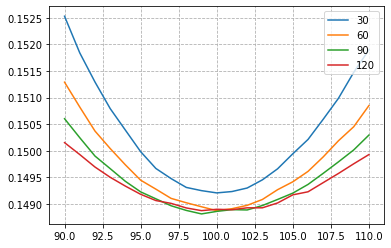

In [36]:
pd.DataFrame(data=impvol_1,columns=np.int64(np.around(texp*252)),index=strike).plot()
plt.legend(loc=1)
plt.grid(linestyle='--')

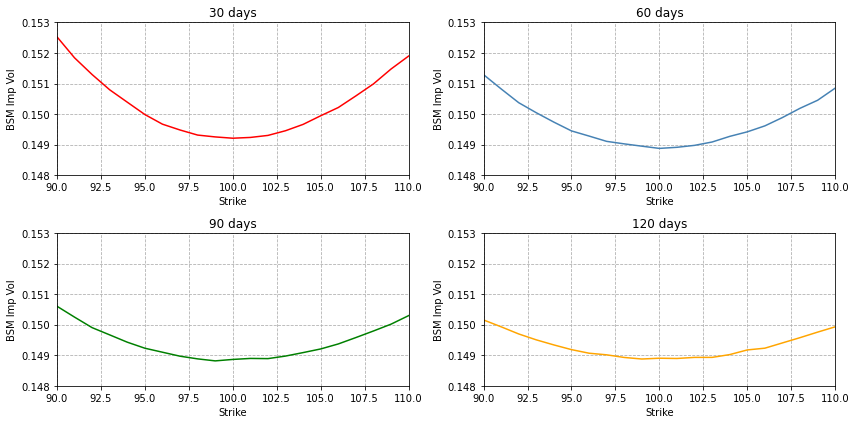

In [37]:
color = ['r', 'steelblue', 'g', 'orange']
plt.figure(figsize=(12,6))
for i in range(len(texp)):
    plt.subplot(221+i)
    plt.axis([90,110,0.148,0.153])
    plt.plot(strike,impvol_1[:,i], c=color[i])
    plt.ylabel('BSM Imp Vol')
    plt.xlabel('Strike')
    plt.title(str(int(round(252*texp[i])))+' days')
    plt.tight_layout()
    plt.grid(linestyle='--')
plt.show()

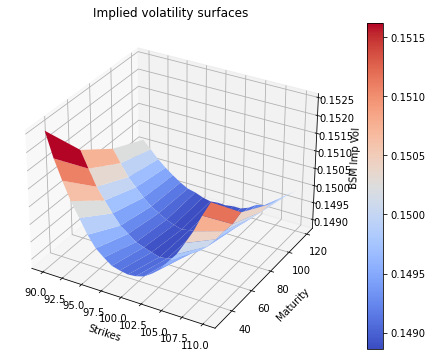

In [38]:
fig=plt.figure(figsize=(12,6))
ax = fig.gca(projection='3d')
surf=ax.plot_surface(strike.reshape(impvol_1.shape[0],1).repeat(impvol_1.shape[1],axis=1),(252*texp).reshape(1,impvol_1.shape[1]).repeat(impvol_1.shape[0],axis=0),impvol_1,cmap=cm.coolwarm)
ax.set_zlabel('BSM Imp Vol')
ax.set_ylabel('Maturity')
ax.set_xlabel('Strikes')
fig.colorbar(surf)
plt.title('Implied volatility surfaces')
plt.show()